##### 25.07. To do:
- romove observations with no nights
- correlation coefficient categorical-numerical
- examine impact group size + nights spent
- redo evaluation of the relationship plots

This notebook will help me understand the data better.

## Basics

In [1]:
# import some packages that I'll need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set color scheme
cpal = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]

# seaborn theme
sns.set()

# use natural numbers
pd.options.display.float_format = "{:.2f}".format


In [2]:
# load the data
TZA = pd.read_csv('data/Train.csv')

In [3]:
# size of the data set
TZA.shape

(4809, 23)

I'm dealing with a data set of almost 5000 observations and 23 features.
Now I want to understand better what each feature means. Zindi provided a data set with feature explanations.

In [4]:
# find out what features mean
variables = pd.read_csv('data/VariableDefinitions.csv')
variables

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


In [5]:
# find out how many values are missing (per column)
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
travel_with,1114,23.16
total_female,3,0.06
total_male,5,0.10
most_impressing,313,6.51


There are many values missing for the travel_with column, almost one fourth. I'll have to learn more about this column to find out how to deal with these values. First I will check if there's a pattern. I use the missingno package for that.

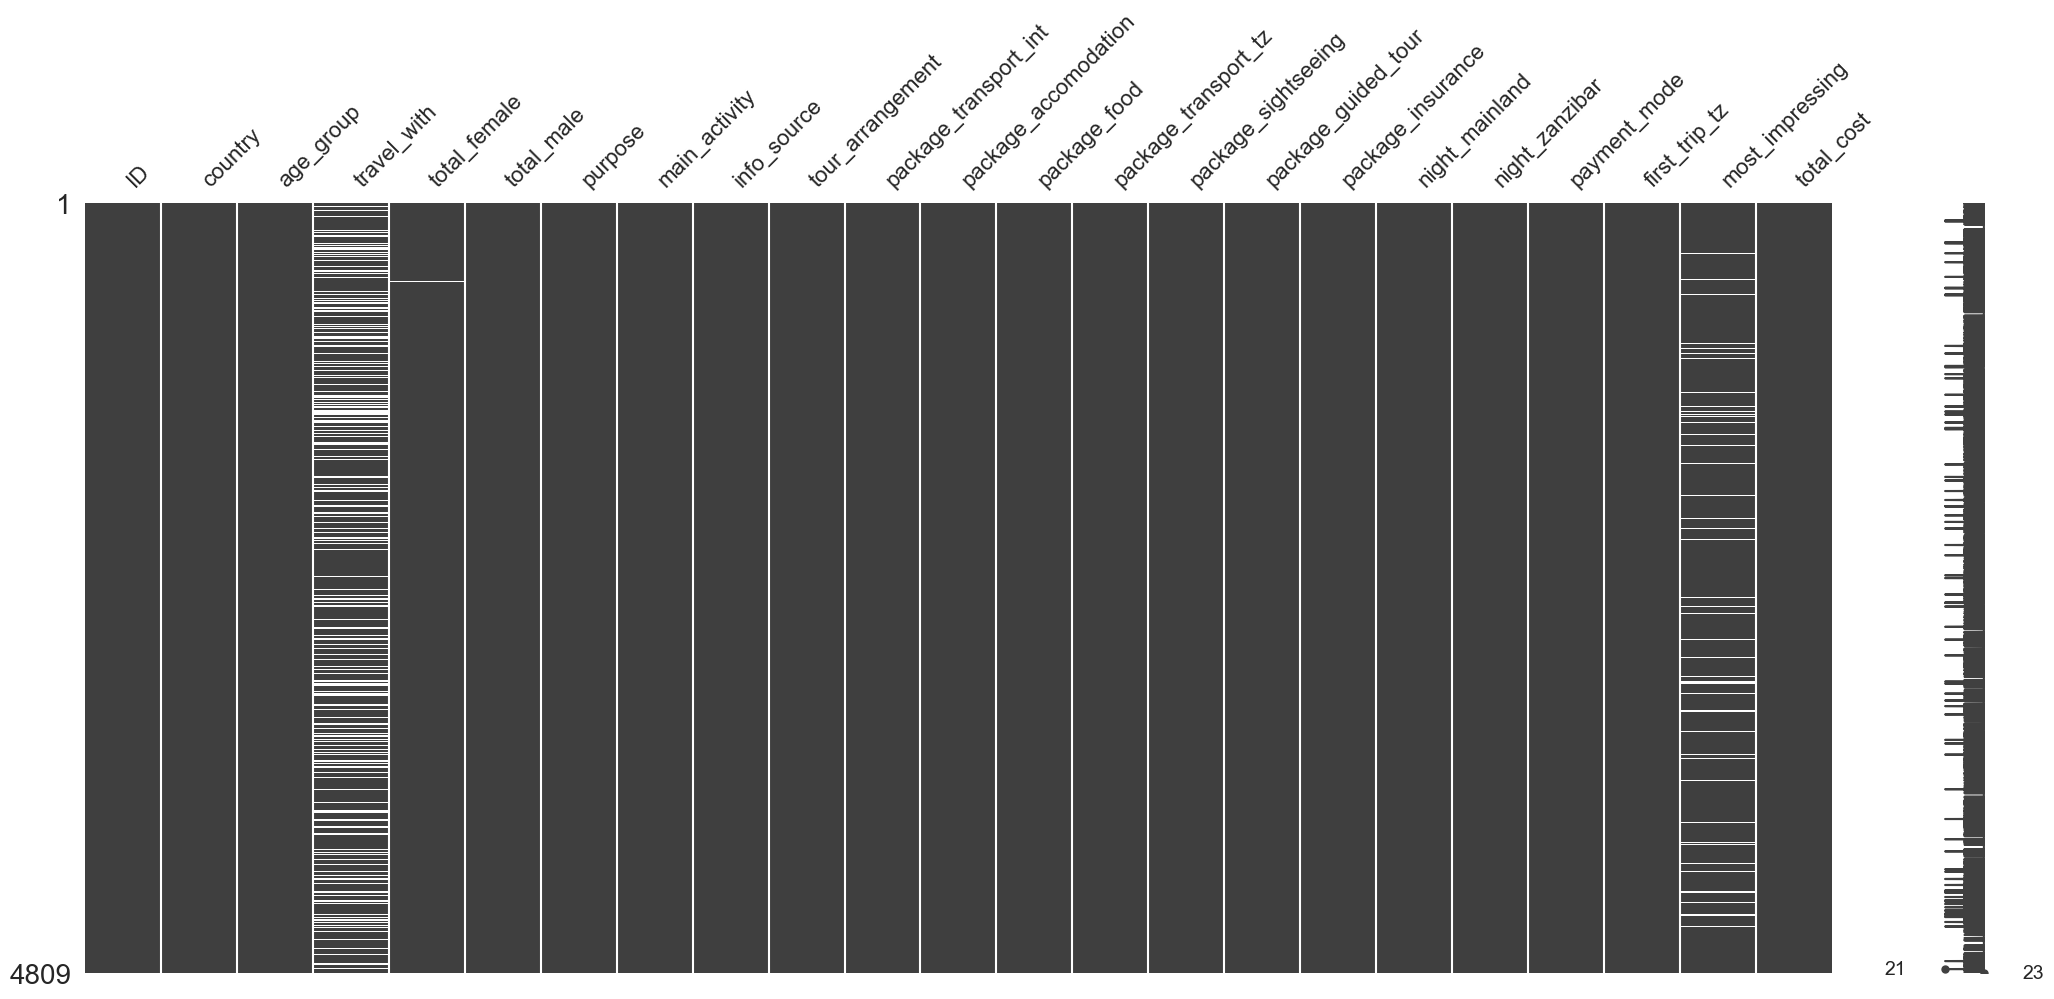

In [6]:
# check for patterns of missing values
import missingno as msno
msno.matrix(TZA);

I can't see an obvious pattern.

In [7]:
# find out which data types I have to deal with
TZA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

I have to deal with many categorical features. This can become a bit tricky because I'll need to encode them all later. Let's check how many unique values each of these columns contain.

In [8]:
TZA.nunique()

ID                       4809
country                   105
age_group                   4
travel_with                 5
total_female               14
total_male                 14
purpose                     7
main_activity               9
info_source                 8
tour_arrangement            2
package_transport_int       2
package_accomodation        2
package_food                2
package_transport_tz        2
package_sightseeing         2
package_guided_tour         2
package_insurance           2
night_mainland             64
night_zanzibar             34
payment_mode                4
first_trip_tz               2
most_impressing             7
total_cost               1637
dtype: int64

The number of unique values of IDs is equal to the number of rows, so this already indicates clearly that there are no duplicates in the data set!

There are tourists from 105 different countries, that's lot. (It may be a good idea to group them by regions/continents later.)

There are some columns which are seemlingly intuitive to understand with each a reasonable amount of unique values, further many columns with only 2 unique values (probably yes/no).

The total_female and total_male columns I don't understand yet but I'll have a look at the dataframe now to see how these values actually look in the bigger context.

In [9]:
# have a first look
TZA.head(10)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.00,0.00,Cash,No,Friendly People,674602.50
1,tour_10,UNITED KINGDOM,25-44,NaN,1.00,0.00,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.50
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.00,1.00,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.00,31.00,Cash,No,Excellent Experience,3315000.00
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.00,0.00,Cash,Yes,Friendly People,7790250.00
4,tour_1004,CHINA,1-24,NaN,1.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.00,4.00,Cash,Yes,No comments,1657500.00
5,tour_1005,UNITED KINGDOM,25-44,NaN,0.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,Yes,No,9.00,3.00,Cash,Yes,Wildlife,120950.00
6,tour_1007,SOUTH AFRICA,45-64,Alone,0.00,1.00,Business,Mountain climbing,"Friends, relatives",Independent,...,No,No,No,No,9.00,0.00,Cash,Yes,Friendly People,466140.00
7,tour_1008,UNITED STATES OF AMERICA,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,10.00,3.00,Cash,Yes,Friendly People,3480750.00
8,tour_101,NIGERIA,25-44,Alone,0.00,1.00,Leisure and Holidays,Cultural tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,4.00,0.00,Cash,Yes,NaN,994500.00
9,tour_1011,INDIA,25-44,Alone,1.00,0.00,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,5.00,0.00,Credit Card,Yes,Friendly People,2486250.00


Ok, now things make more sense: 

Contrary to my first assumption that there is a single tourist behind each ID, there is apparently a group of tourists behind each ID (or only one tourist when travelling alone).

As expected, many columns simply contain yes/no entries.

The column travel_with, in which so many values are missing, becomes much clearer to me now: Obviously there are simply single travelers behind it. I'll check that now and impute the columns right away (for my EDA only).

I need a new column first which shows the size of travel group, I'll simple add the total_female and total_male.

In [10]:
# add new column with group size
TZA['group_size'] = TZA['total_female'] + TZA['total_male']

Now I check whether all travel_with NaNs do have a group size of 1.

In [11]:
# check relation of NaNs and group size
df_NaN = pd.crosstab(TZA['group_size'], TZA['travel_with'].fillna('missing'), normalize='index').mul(100).round(2)
df_NaN.head(50)

travel_with,Alone,Children,Friends/Relatives,Spouse,Spouse and Children,missing
group_size,,,,,,
0.00,26.67,0.00,40.00,13.33,13.33,6.67
1.00,53.10,0.04,0.55,0.55,0.00,45.76
2.00,0.00,5.88,32.34,60.36,0.56,0.87
3.00,0.00,13.46,40.71,2.88,41.67,1.28
4.00,0.38,6.04,33.96,1.13,56.98,1.51
5.00,0.00,5.43,36.96,0.00,56.52,1.09
6.00,0.00,0.00,60.78,0.00,37.25,1.96
7.00,0.00,6.25,56.25,6.25,25.00,6.25
8.00,0.00,8.33,91.67,0.00,0.00,0.00


It seems that my assumption was not bad, but it doesn't cover all cases. For the imputation of the travel_with column I'll rather do the following: If the group size is 1 I'll impute with "alone", if it is bigger than 1 I'll just impute with "missing".

Looking at this also makes me aware of some other issues that I have to have a look at later:
- How can a travel group consist of zero people?
- Is 93 still a reasonable group size?
- How can a group of 4 or 15 be considered an alone traveller?
- How can a group of more than 2 be considered "travelled with spouse"? I understood that this means a couple (of 2) was travelling...

So let's start with some 

## Data Cleaning

First I want to impute the missing values in the travel_with column with "missing"/"Alone".

In [12]:
# fill missing values with "missing"
TZA['travel_with'] = TZA['travel_with'].fillna('missing')

In [13]:
# replace travel_with by "Alone" if group size is 1
TZA.loc[TZA.group_size == 1, 'travel_with'] = 'Alone'

We saw earlier that there are also values missing in the most_impressing column. Let's have a look at the unique values of this column.

In [14]:
# check unique values in most_impressing column
TZA['most_impressing'].unique()

array(['Friendly People', 'Wonderful Country, Landscape, Nature',
       'Excellent Experience', 'No comments', ' Wildlife', nan,
       'Good service', 'Satisfies and Hope Come Back'], dtype=object)

There's already one value "no comments" - I'll also fill the NaN values with this one.

In [15]:
# fill missing values with "No comments"
TZA['most_impressing'] = TZA['most_impressing'].fillna('No comments')

# check again unique values
TZA['most_impressing'].unique()

array(['Friendly People', 'Wonderful Country, Landscape, Nature',
       'Excellent Experience', 'No comments', ' Wildlife', 'Good service',
       'Satisfies and Hope Come Back'], dtype=object)

Now let's check again if the NaNs in travel_with and most_impressing are gone...

In [16]:
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
total_female,3,0.06
total_male,5,0.10
group_size,8,0.17


They are! That's good. But there are still some values missing in the total_female and total_male columns, and our newly created column group_size also contains NaNs. This was produced by calculating with the other NaNs earlier. So we have to correct that now. 
First let's have a look at the columns with missing total_female and total_male.

In [17]:
TZA[TZA['total_female'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
490,tour_1604,FRANCE,25-44,Friends/Relatives,NaN,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,9.00,5.00,Cash,Yes,No comments,313000.00,NaN
545,tour_1678,ITALY,1-24,Friends/Relatives,NaN,4.00,Volunteering,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,15.00,0.00,Cash,Yes,No comments,9077320.00,NaN
1261,tour_2547,FRANCE,25-44,Friends/Relatives,NaN,1.00,Leisure and Holidays,Wildlife tourism,"Newspaper, magazines,brochures",Package Tour,...,Yes,Yes,Yes,7.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature",324300.00,NaN


In [18]:
TZA[TZA['total_male'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
1017,tour_2246,UNITED STATES OF AMERICA,45-64,Friends/Relatives,4.00,NaN,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,19.00,0.00,Cash,Yes,No comments,7293000.00,NaN
1473,tour_2810,SPAIN,45-64,Friends/Relatives,7.00,NaN,Other,Hunting tourism,"Travel, agent, tour operator",Package Tour,...,No,No,Yes,11.00,0.00,Cash,No,"Wonderful Country, Landscape, Nature",56960183.00,NaN
2449,tour_3980,SOUTH AFRICA,25-44,Friends/Relatives,0.00,NaN,Meetings and Conference,Wildlife tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,4.00,0.00,Credit Card,Yes,Friendly People,3978000.00,NaN
2494,tour_4031,FRANCE,25-44,missing,0.00,NaN,Leisure and Holidays,Conference tourism,"Radio, TV, Web",Package Tour,...,Yes,Yes,Yes,6.00,0.00,Cash,Yes,Excellent Experience,4309500.00,NaN
3984,tour_5838,CHINA,25-44,Friends/Relatives,10.00,NaN,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,4.00,2.00,Cash,Yes,Wildlife,89505000.00,NaN


For lack of other clues, I'll just assume that in these cases NaN equals 0. I'll impute these NaNs accordingly.

In [19]:
# fill missing values with 0
TZA['total_male'] = TZA['total_male'].fillna(0)
TZA['total_female'] = TZA['total_female'].fillna(0)

Now I'll apply the group_size calculation again.

In [20]:
# calculate group size again
TZA['group_size'] = TZA['total_female'] + TZA['total_male']

I also replace once again travel_with by Alone if the group size is 1.

In [21]:
TZA.loc[TZA.group_size == 1, 'travel_with'] = 'Alone'

In [22]:
# check again for missing values 
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage


Great! No more missing values!

We saw some other irregularities before. There were group sizes of zero. Let's have a look at them.

In [23]:
TZA.loc[TZA['group_size'] == 0]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
170,tour_1205,UNITED STATES OF AMERICA,25-44,Spouse,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Radio, TV, Web",Package Tour,...,No,Yes,No,5.00,4.00,Credit Card,No,Excellent Experience,1657500.00,0.00
705,tour_1867,HUNGARY,45-64,Spouse and Children,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,4.00,0.00,Cash,Yes,Wildlife,7646047.50,0.00
706,tour_1869,UNITED STATES OF AMERICA,45-64,missing,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,Yes,7.00,0.00,Cash,Yes,No comments,21713250.00,0.00
727,tour_1893,UNITED STATES OF AMERICA,45-64,Spouse and Children,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,20.00,0.00,Cash,Yes,Friendly People,19227000.00,0.00
1154,tour_2414,GERMANY,45-64,Friends/Relatives,0.00,0.00,Leisure and Holidays,Beach tourism,"Newspaper, magazines,brochures",Package Tour,...,No,No,No,0.00,33.00,Cash,Yes,Wildlife,67399101.00,0.00
1670,tour_3040,ZIMBABWE,1-24,Alone,0.00,0.00,Business,Beach tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,2.00,0.00,Cash,No,No comments,500000.00,0.00
2243,tour_3730,UNITED STATES OF AMERICA,65+,Spouse,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,No,No,14.00,0.00,Cash,Yes,Wildlife,16939650.00,0.00
2335,tour_3840,SPAIN,25-44,Alone,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,No,4.00,0.00,Cash,Yes,"Wonderful Country, Landscape, Nature",447525.00,0.00
2430,tour_396,AUSTRALIA,1-24,Alone,0.00,0.00,Leisure and Holidays,Hunting tourism,"Travel, agent, tour operator",Independent,...,No,No,No,15.00,5.00,Cash,Yes,Friendly People,11027030.00,0.00
2449,tour_3980,SOUTH AFRICA,25-44,Friends/Relatives,0.00,0.00,Meetings and Conference,Wildlife tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,4.00,0.00,Credit Card,Yes,Friendly People,3978000.00,0.00


So for these 17 observations we don't have the information how big the travel group was. We can assume that those who travelled "alone" were 1, and those who travelled with "spouse" were 2. 
We don't know for sure, and it's only 17 observations. I'll just remove these rows for my EDA.

In [24]:
# only keep rows with group size greater than 0
TZA = TZA[TZA.group_size > 0]

# check whether 17 rows were deleted
TZA.shape

(4792, 24)

Now I also want to delete all columns, in which the travel_with and group_size columns obviously don't make sense together:
- Alone travellers with group size not equal to 1
- With Spouse travellers with group size not equal to 2

In [25]:
# find the indexes of the rows where the mentioned conditions apply
indexAlone = TZA[ (TZA['group_size'] != 1) & (TZA['travel_with'] == 'Alone') ].index
indexSpouse = TZA[ (TZA['group_size'] != 2) & (TZA['travel_with'] == 'Spouse') ].index

# drop these rows
TZA.drop(indexAlone, inplace=True)
TZA.drop(indexSpouse, inplace=True)

Now have a look again at the crosstab we already used earlier. Do things make more sense now?

In [26]:
df_NaN2 = pd.crosstab(TZA['group_size'], TZA['travel_with'], normalize='index').mul(100).round(2)
df_NaN2.head(50)

travel_with,Alone,Children,Friends/Relatives,Spouse,Spouse and Children,missing
group_size,,,,,,
1.00,100.00,0.00,0.00,0.00,0.00,0.00
2.00,0.00,5.88,32.34,60.36,0.56,0.87
3.00,0.00,13.86,41.91,0.00,42.90,1.32
4.00,0.00,6.08,34.98,0.00,57.41,1.52
5.00,0.00,5.43,36.96,0.00,56.52,1.09
6.00,0.00,0.00,60.78,0.00,37.25,1.96
7.00,0.00,6.25,62.50,0.00,25.00,6.25
8.00,0.00,8.33,91.67,0.00,0.00,0.00
9.00,0.00,0.00,75.00,0.00,12.50,12.50


Yes! We got rid of some values which don't make sense. 

Now it's time to check for obvious outliers. I'll plot boxplots for the numeric features in my data set. (*not meant to be super beautiful, only for my better understanding*)

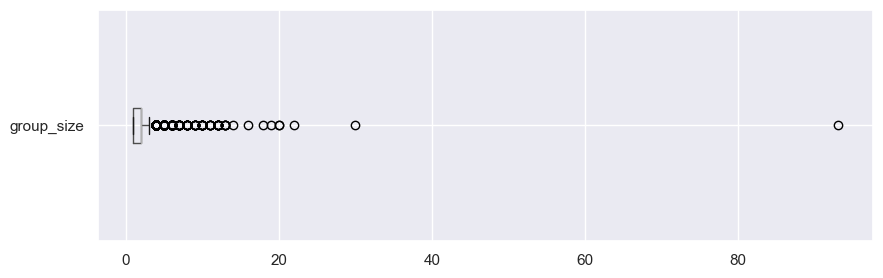

In [27]:
TZA.boxplot(column='group_size', vert=False, figsize= [10,3]);

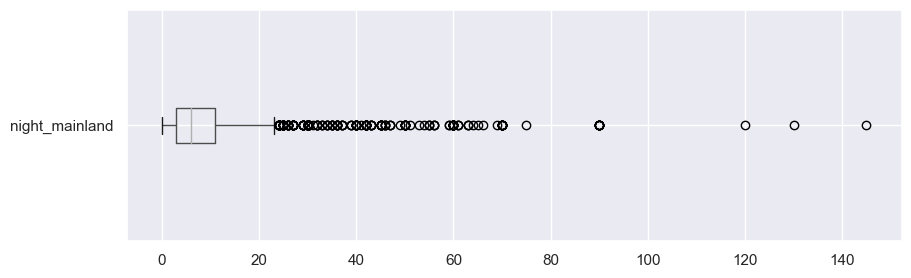

In [28]:
TZA.boxplot(column='night_mainland', vert=False, figsize= [10,3]);

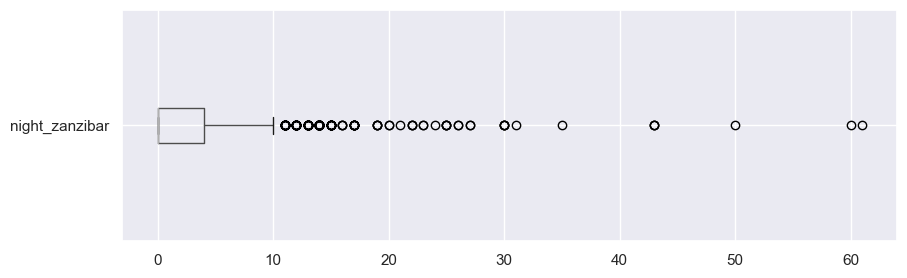

In [29]:
TZA.boxplot(column='night_zanzibar', vert=False, figsize= [10,3]);

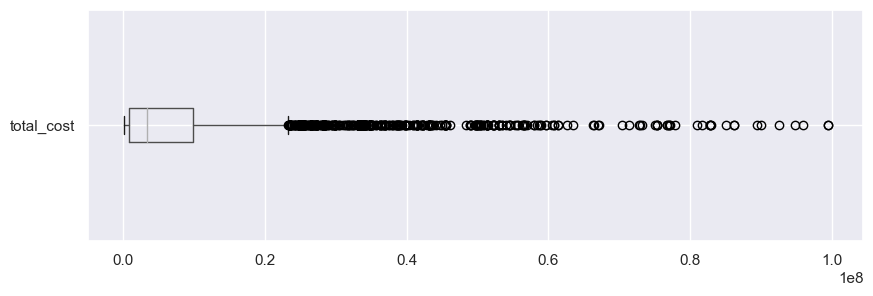

In [30]:
TZA.boxplot(column='total_cost', vert=False, figsize= [10,3]);

I also check the basic statistics:

In [31]:
TZA.describe()

,total_female,total_male,night_mainland,night_zanzibar,total_cost,group_size
count,4776.00,4776.00,4776.00,4776.00,4776.00,4776.00
mean,0.92,1.01,8.50,2.28,8086529.34,1.93
std,1.27,1.14,10.45,4.12,12204420.40,2.07
min,0.00,0.00,0.00,0.00,49000.00,1.00
25%,0.00,1.00,3.00,0.00,794265.50,1.00
50%,1.00,1.00,6.00,0.00,3357182.50,2.00
75%,1.00,1.00,11.00,4.00,9785313.90,2.00
max,49.00,44.00,145.00,61.00,99532875.00,93.00


Is it realistic that a travel group consists of 93? Or that a group spends almost 40.000 € for their holidays? That someone stays almost 5 months on holidays? Not sure, definitely not a *common* behavior, but why not in single cases? I decide to keep the outliers!

In the other notebook Get_regions I stumbled over some country names in this dataset which I want to correct here. I also change the notation a bit. The following steps are a bit confusing, this has resulted from the other notebook.

In [32]:
# change to lower cases
TZA['country'] = TZA['country'].str.lower()
# capitalize first letter
TZA['country'] = TZA['country'].str.capitalize()

In [33]:
# change some country names
TZA = TZA.replace({'country' : {'United states of america': 'United States', 'Swaziland' : 'Eswatini', 'Cape verde' : 'Cabo Verde', 'Swizerland' : 'Switzerland', 'Ukrain' : 'Ukraine','Malt' : 'Malta', 'Burgaria' : 'Bulgaria', 'Korea' : 'South Korea', 'Comoro' : 'Comoros', 'Scotland' : 'United Kingdom', 'russia' : 'Russian Federation', 'sri lanka': 'SriLanka', }})
TZA = TZA.replace({'country' : {'Ivory coast': "Côte d'Ivoire", 'Drc' : 'Congo', 'Uae' : 'United arab emirates', 'Trinidad tobacco' : 'Trinidad and Tobago', 'Costarica' : 'Costa Rica', 'Philipines' : 'Philippines', 'Djibout' : 'Djibouti', 'Morroco' : 'Morocco'}})

I repeat the other steps once again because I need a uniform spelling.

In [34]:
#change to lower cases
TZA['country'] = TZA['country'].str.lower()
# capitalize first letter
TZA['country'] = TZA['country'].str.capitalize()

Before I start with the EDA I come up with some...

## Hypotheses

- The bigger a group is, the more money they spend.
- The longer a group stays, the more money they spend.
- The more extras a group books, the more money they spend.
- Arranged tours are more expensive than independent tours.
- Tourists from wealthier countries spend more money.
- Older tourists spend more than younger tourists.
- The purpose of the tour has an impact on how much money a group spends.

## EDA

Let's start with exploring the data. First we want to understand the distributions better, later we'll check the relationships between the features, especially towards the target variable.

### Distributions

Let's start with the countries. We have tourists from 105 different countries in our data set!

I'll now add the subregions to my original dataframe. For this step it is important that the country names in both data frames are exactly the same.

In [35]:
# get subregions and delete unnecessary column
subregions = pd.read_csv('data/subregions.csv')
subregions.drop(['Unnamed: 0'], axis=1, inplace=True)
subregions

,country,sub_region
0,Afghanistan,Southern Asia
1,Åland islands,Northern Europe
2,Albania,Southern Europe
3,Algeria,Northern Africa
4,American samoa,Polynesia
...,...,...
244,Wallis and futuna,Polynesia
245,Western sahara,Northern Africa
246,Yemen,Western Asia
247,Zambia,Sub-Saharan Africa


In [36]:
# merge the subregions into the TZA dataframe
TZA = pd.merge(TZA, subregions, how ='left')

Let's first have a look at the distribution of countries.

In [37]:
# get percentages and counts per country
percentage_c = TZA['country'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
counts_c = TZA['country'].value_counts()

# concatenate percentages and counts in a new dataframe and show it
countries = pd.concat([counts_c,percentage_c], axis=1, keys=['count', 'percentage'])
countries

,count,percentage
country,,
United states,691,14.5%
United kingdom,534,11.2%
Italy,391,8.2%
France,275,5.8%
Zimbabwe,272,5.7%
...,...,...
Niger,1,0.0%
Myanmar,1,0.0%
Dominica,1,0.0%


Most visitors come from US and UK. Let's print the top 10 countries with most tourists.

In [38]:
def plot_percentage_hor(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

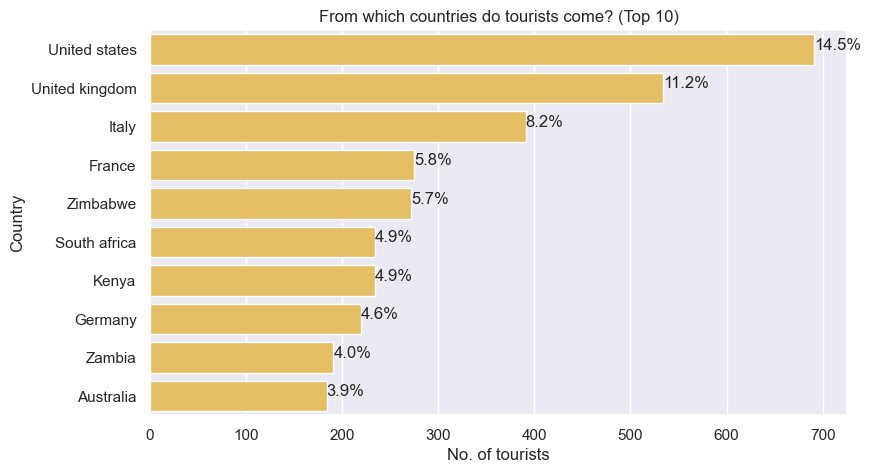

In [81]:
# plot the top 10 countries

country_order = TZA['country'].value_counts().head(10).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, y='country', order=country_order, color = "#f9c74f")
plot_percentage_hor(ax, TZA.age_group)
plt.title('From which countries do tourists come? (Top 10)')
plt.xlabel('No. of tourists')
plt.ylabel('Country');

And now I do the same for the subregions!

In [40]:
# get percentages and counts per subregion

percentage_s = TZA['sub_region'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
counts_s = TZA['sub_region'].value_counts()

# concatenate percentages and counts in a new dataframe and show it
sub_regions = pd.concat([counts_s,percentage_s], axis=1, keys=['count', 'percentage'])
sub_regions

,count,percentage
sub_region,,
Sub-Saharan Africa,1291,27.0%
Northern America,805,16.9%
Western Europe,739,15.5%
Northern Europe,677,14.2%
Southern Europe,581,12.2%
Australia and New Zealand,202,4.2%
Eastern Asia,139,2.9%
Western Asia,120,2.5%
Southern Asia,100,2.1%


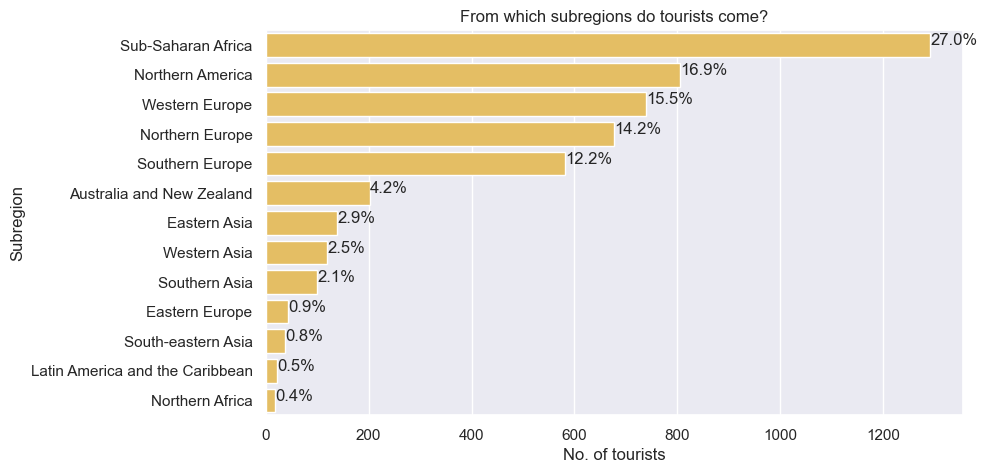

In [82]:
# plot the subregions

subregion_order = TZA['sub_region'].value_counts().head(TZA['sub_region'].nunique()).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, y='sub_region', order=subregion_order, color = "#f9c74f")
plot_percentage_hor(ax, TZA.sub_region)
plt.title('From which subregions do tourists come?')
plt.xlabel('No. of tourists')
plt.ylabel('Subregion');

We have seen that most of the tourists are from US and UK. When we then had a look at the tourists per sub-region, we saw that by far most of them come from Tanzania's own region, sub-Saharan Africa.

Now let's have a look at the age groups.

In [42]:
def plot_percentage_ver(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

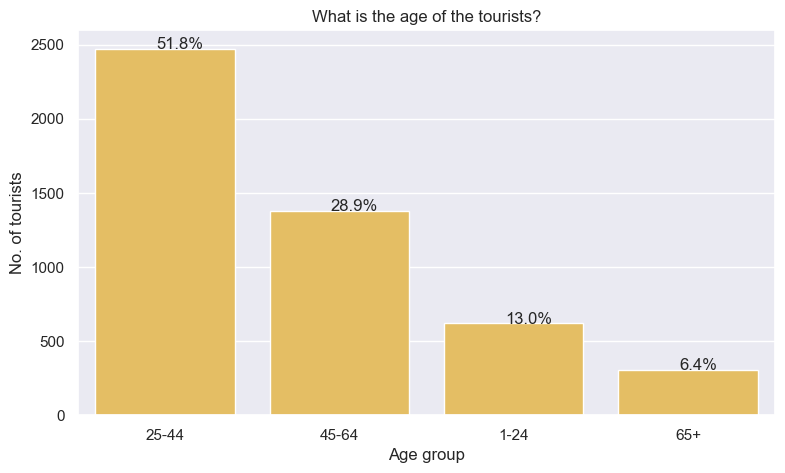

In [83]:
# plot the age groups

age_order = TZA['age_group'].value_counts().head(TZA['age_group'].nunique()).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, x='age_group', order=age_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.age_group)
plt.title('What is the age of the tourists?')
plt.xlabel('Age group')
plt.ylabel('No. of tourists');

Most tourists are young or middle aged adults.

Now let's see who the tourists usually travel with.

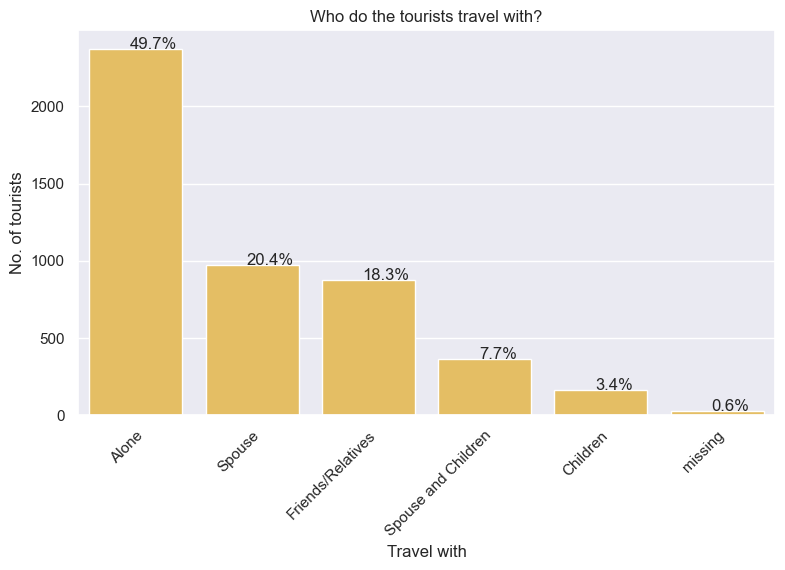

In [84]:
# plot travel with

travel_with_order = TZA['travel_with'].value_counts().head(TZA['travel_with'].nunique()).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, x='travel_with', order=travel_with_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.travel_with)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Who do the tourists travel with?')
plt.xlabel('Travel with')
plt.ylabel('No. of tourists');

Almost half of the tourists travel alone.

Now let's plot some more of the categorical variables.

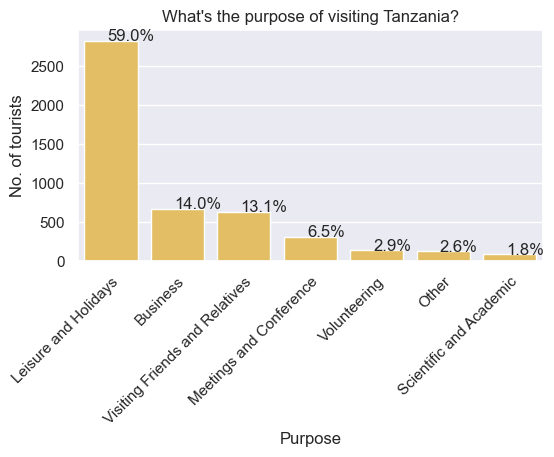

In [85]:
# purpose of travel
purpose_order = TZA['purpose'].value_counts().head(TZA['purpose'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='purpose', order=purpose_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.purpose)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the purpose of visiting Tanzania?')
plt.xlabel('Purpose')
plt.ylabel('No. of tourists');

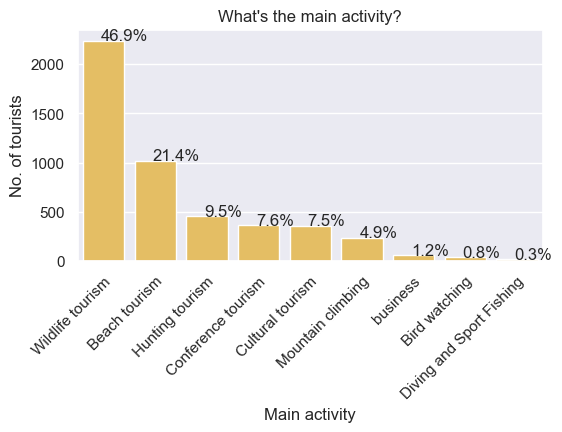

In [86]:
# main_activity
main_activity_order = TZA['main_activity'].value_counts().head(TZA['main_activity'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='main_activity', order=main_activity_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.main_activity)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the main activity?')
plt.xlabel('Main activity')
plt.ylabel('No. of tourists');

Most tourists visited Tanzania for Leisure and Holidays, with Wildlife tourism being the most important activity.

Now let's see which source the tourists mostly use for information.

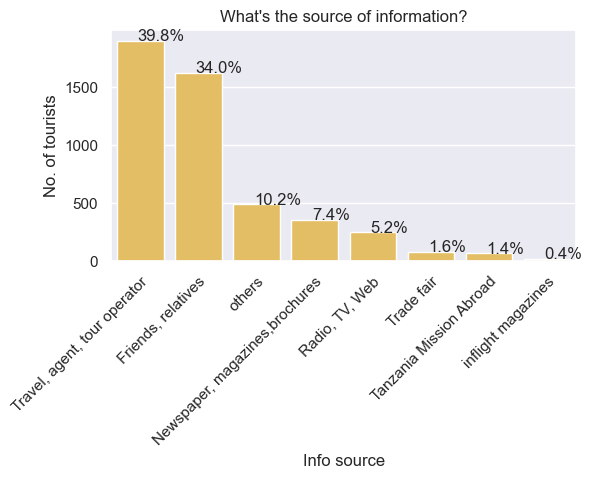

In [87]:
# info_source
info_source_order = TZA['info_source'].value_counts().head(TZA['info_source'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='info_source', order=info_source_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.info_source)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the source of information?')
plt.xlabel('Info source')
plt.ylabel('No. of tourists');

Interesting that "web" (in one category with radio and TV) doesn't seem to play a big role here.

Now I check wheather tourists books their holidays independently or as a package/arrangement:

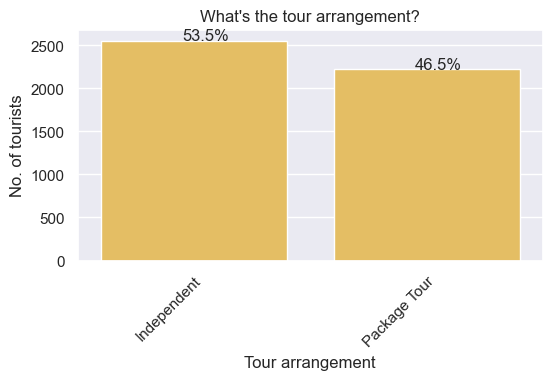

In [90]:
# tour_arrangement
tour_arrangement_order = TZA['tour_arrangement'].value_counts().head(TZA['tour_arrangement'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='tour_arrangement', order=tour_arrangement_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.tour_arrangement)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the tour arrangement?')
plt.xlabel('Tour arrangement')
plt.ylabel('No. of tourists');

Slightly more tourists travel independently. 

Now I want to check those who booked a package: Which services were included? I first create a new dataframe with the relevant columns only.

In [49]:
# create new dataframe
tourarrangement = TZA[['tour_arrangement','package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance']].copy()

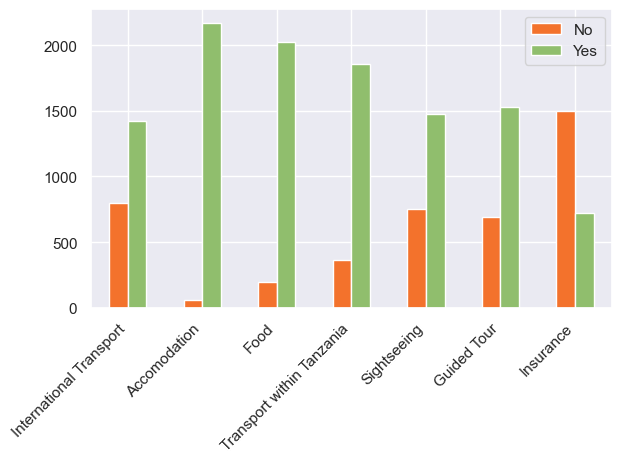

In [94]:
# filter on those with package
packages_tourarrangements = tourarrangement[(tourarrangement.tour_arrangement == 'Package Tour')]
#remove tour_arrangement column
packages_tourarrangements = packages_tourarrangements.drop(['tour_arrangement'], axis=1)

#plot which services were booked
packages_tourarrangements_num = packages_tourarrangements.apply(pd.value_counts).T
ax=packages_tourarrangements_num.plot.bar(color = {'Yes': "#90be6d", 'No':'#f3722c'}, edgecolor='White')
ax.set_xticklabels(['International Transport', 'Accomodation',
       'Food', 'Transport within Tanzania', 'Sightseeing',
       'Guided Tour', 'Insurance'], rotation=45, ha="right")
#needs improvement
# for col in packages_num.columns:
#    plot_percentage_ver(ax, col)
plt.tight_layout()
plt.show();

We see that most packages include accomodation, followed by food and transport in Tanzania. Most tourists didn't book an insurance.

Now I want to have a look into the duration of stay. For this I will first sum the nights on mainland and on Zanzibar and then bin the durations in buckets of weeks.

In [51]:
# create new column with total nights
TZA['total_nights'] = TZA['night_mainland'] + TZA['night_zanzibar']

In [52]:
# define bins and labels
bins = [-1,0,7,14,21,28,56,1000]
labels = ['none','up to 1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '4-8 weeks', 'more than 8 weeks']

# bin all nights columns accordingly
TZA['nights_mainland_binned'] = pd.cut(TZA['night_mainland'], bins=bins, labels=labels)
TZA['nights_zanzibar_binned'] = pd.cut(TZA['night_zanzibar'], bins=bins, labels=labels)
TZA['total_nights_binned'] = pd.cut(TZA['total_nights'], bins=bins, labels=labels)

# have a look on these columns together
TZA[['night_mainland', 'nights_mainland_binned', 'night_zanzibar', 'nights_zanzibar_binned', 'total_nights', 'total_nights_binned']]

,night_mainland,nights_mainland_binned,night_zanzibar,nights_zanzibar_binned,total_nights,total_nights_binned
0,13.00,1-2 weeks,0.00,none,13.00,1-2 weeks
1,14.00,1-2 weeks,7.00,up to 1 week,21.00,2-3 weeks
2,1.00,up to 1 week,31.00,4-8 weeks,32.00,4-8 weeks
3,11.00,1-2 weeks,0.00,none,11.00,1-2 weeks
4,7.00,up to 1 week,4.00,up to 1 week,11.00,1-2 weeks
...,...,...,...,...,...,...
4771,2.00,up to 1 week,0.00,none,2.00,up to 1 week
4772,11.00,1-2 weeks,0.00,none,11.00,1-2 weeks
4773,3.00,up to 1 week,7.00,up to 1 week,10.00,1-2 weeks
4774,5.00,up to 1 week,0.00,none,5.00,up to 1 week


And now let's plot the total nights.

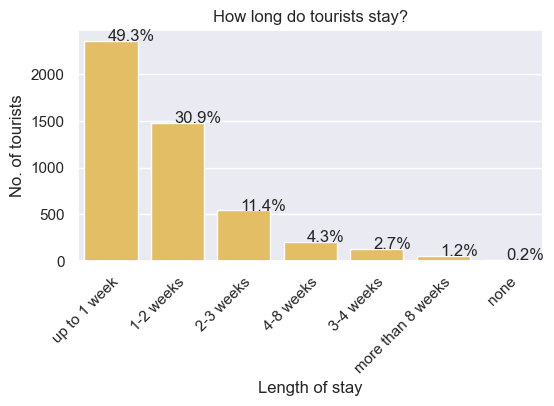

In [95]:
# total_nights
total_nights_binned_order = TZA['total_nights_binned'].value_counts().head(TZA['total_nights_binned'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='total_nights_binned', order=total_nights_binned_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.total_nights_binned)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('How long do tourists stay?')
plt.xlabel('Length of stay')
plt.ylabel('No. of tourists');

Most tourists don't stay very long, almost half of them for a week at most. Not even 20 percent stay longer than 2 weeks. 
I see that there are 'none' values which means 0 total nights... This doesn't make much sense. For the model later I should also remove these obersations.

Now let's check the payment modes.

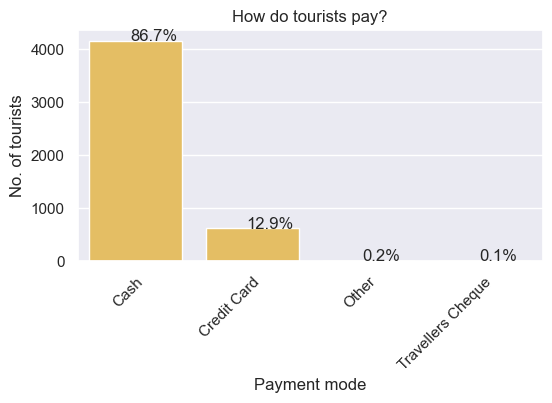

In [96]:
# payment_mode
payment_mode_order = TZA['payment_mode'].value_counts().head(TZA['payment_mode'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='payment_mode', order=payment_mode_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.payment_mode)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('How do tourists pay?')
plt.xlabel('Payment mode')
plt.ylabel('No. of tourists');

By far most pay cash.

Now I check how many tourists visit Tanzania for the first time.

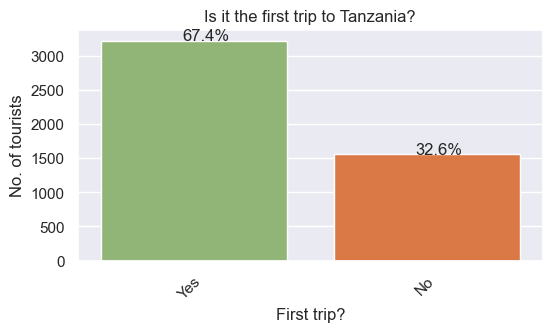

In [97]:
# first_trip_tz
first_trip_tz_order = TZA['first_trip_tz'].value_counts().head(TZA['first_trip_tz'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='first_trip_tz', order=first_trip_tz_order, palette = ["#90be6d", '#f3722c'])
plot_percentage_ver(ax, TZA.first_trip_tz)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Is it the first trip to Tanzania?')
plt.xlabel('First trip?')
plt.ylabel('No. of tourists');

67% visit Tanzania for the first time.

What impresses tourists most when visiting Tanzania?

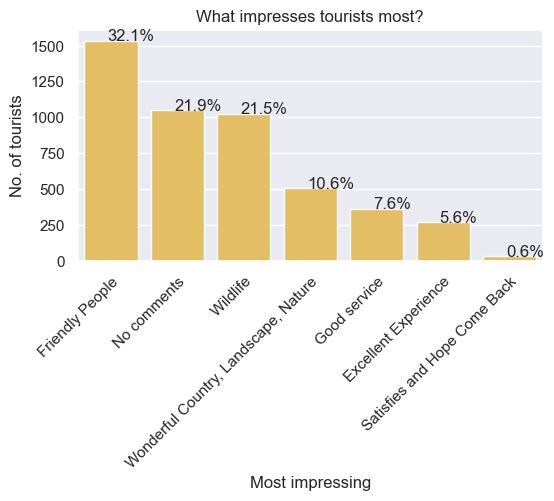

In [98]:
# most_impressing
most_impressing_order = TZA['most_impressing'].value_counts().head(TZA['most_impressing'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='most_impressing', order=most_impressing_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.most_impressing)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What impresses tourists most?')
plt.xlabel('Most impressing')
plt.ylabel('No. of tourists');

Most tourists were impressed by the friendy people.

And now let's check the final column, our target variable late for the model: the total cost! The column in the data set is in Tanzanian Schilling. I convert it to Euro, so it is easier for me to understand the numbers.

In [57]:
TZA['total_cost_Euro'] = TZA['total_cost'] * 0.00038
TZA['total_cost_Euro'].describe()

count    4776.00
mean     3072.88
std      4637.68
min        18.62
25%       301.82
50%      1275.73
75%      3718.42
max     37822.49
Name: total_cost_Euro, dtype: float64

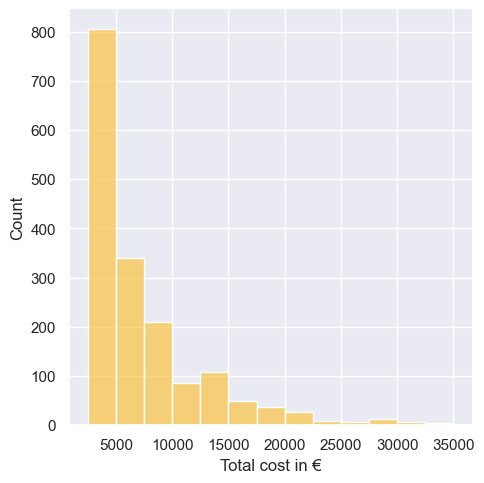

In [102]:
g = sns.displot(
  data=TZA,
  x="total_cost_Euro",
  kind="hist", 
  bins=[2499.5, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000.5], color = '#f9c74f')
plt.xlabel('Total cost in €');

Most tourist groups spend between 2500 and 5000 € for their trip.

### Relationships

So far, we have looked at the individual features independently. Now we want to see how they relate to each other, if there are correlations, etc.

Let's start with a simple correlation heatmap. (We can only show numeric features in a correlation matrix.)

In [103]:
cpal

['#f94144',
 '#f3722c',
 '#f8961e',
 '#f9844a',
 '#f9c74f',
 '#90be6d',
 '#43aa8b',
 '#4d908e',
 '#577590',
 '#277da1']

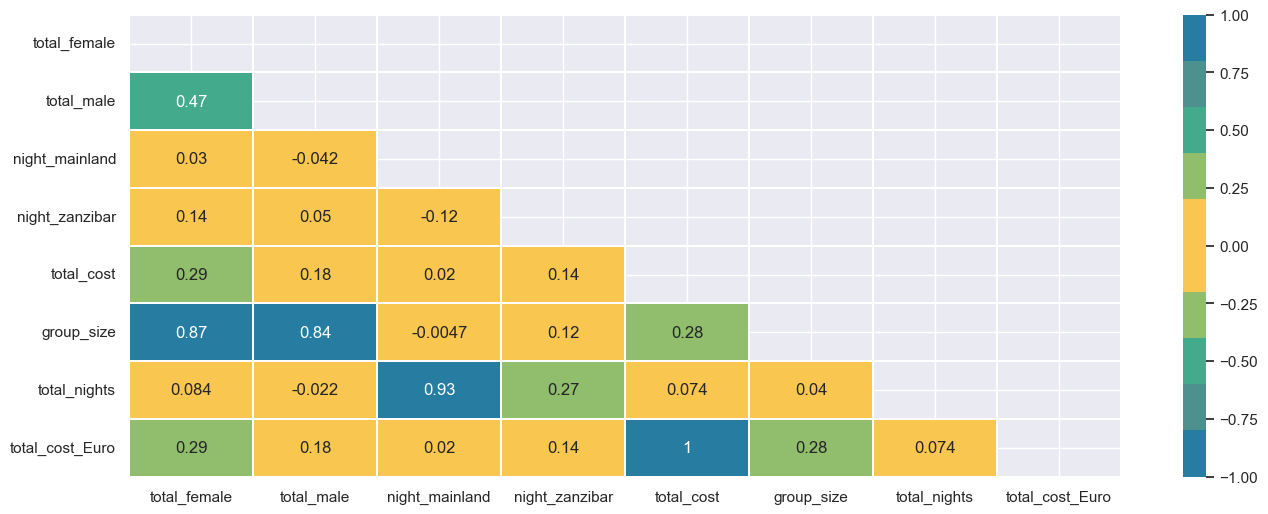

In [114]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(TZA.corr(numeric_only=True), dtype=bool))
correlations = sns.heatmap(TZA.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, linewidths=0.005, linecolor='white', cmap = ['#277da1', '#4d908e', '#43aa8b', '#90be6d', '#f9c74f', '#f9c74f', '#90be6d','#43aa8b', '#4d908e', '#277da1'], mask=mask);

This plot shows us the correlation coefficients between the numeric features. A coefficient of 1 means perfect positive correlation, -1 means perfect negative correlation and 0 means no correlation at all.

We see:
- very strong correlation between group size and total_male
- very strong correlation between group size and total_female
- moderate correlation between total_male and total_female
- weak correlation between group size/total_female/total_male and total_cost

total_cost is our target variable and we aim to find out by which features it is influenced. 
It's interesting that it is not that much influenced by the travel group size and even less by the nights spent in Tanzania. These were hypotheses earlier, and I must say I really believed these features were more influencing. 

Now let's make some scatterplots to visualize the relationships between the numerical features.

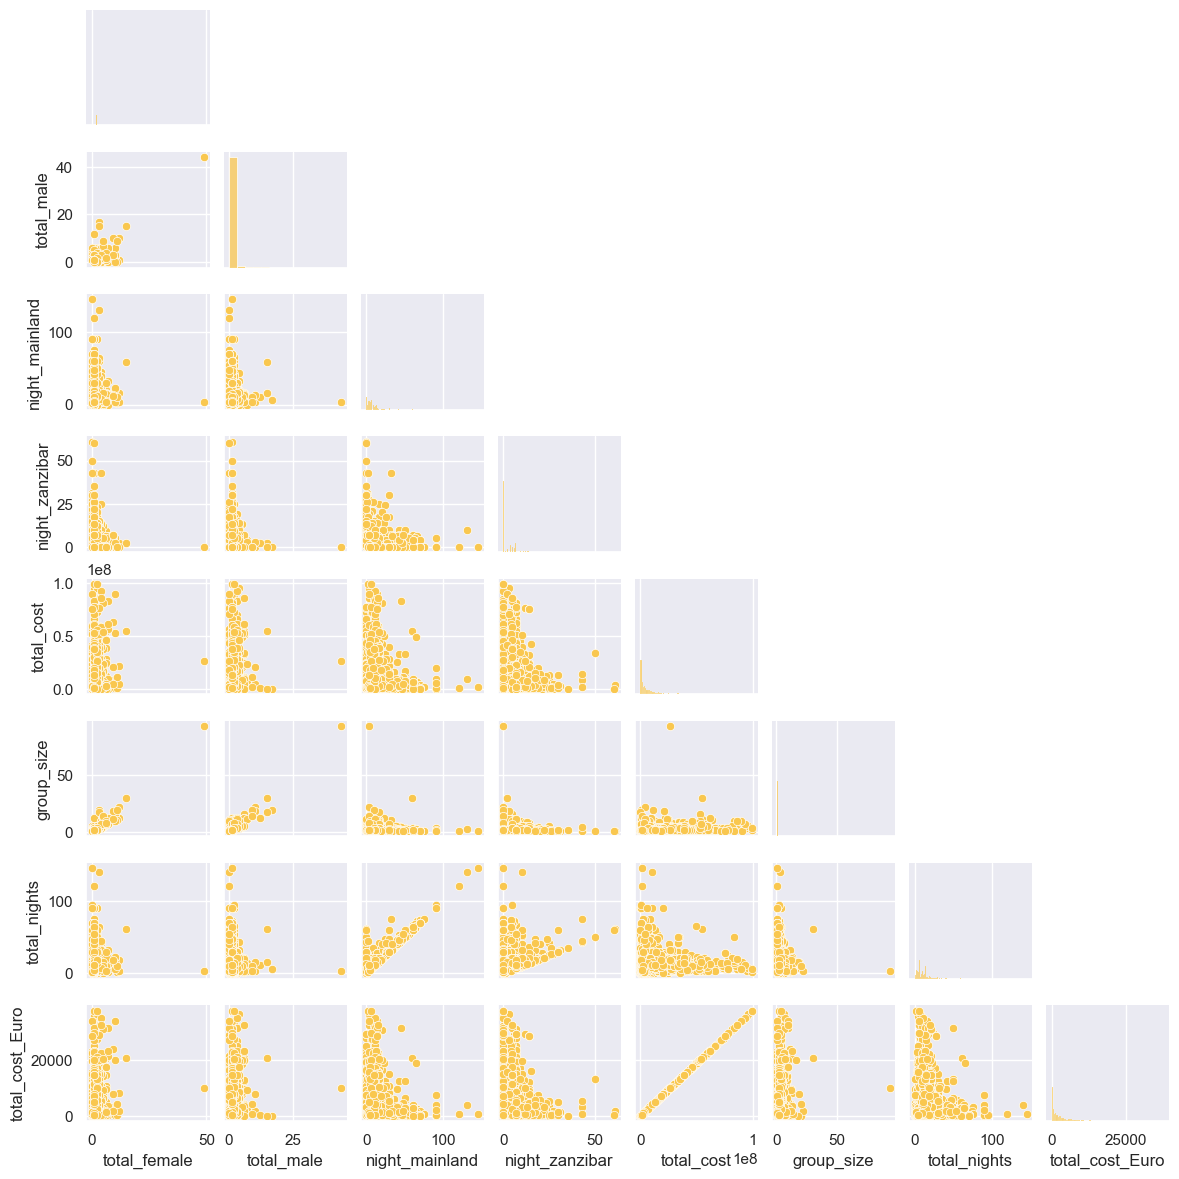

In [116]:
sns.pairplot(TZA, corner=True, height=1.5, palette = cpal, plot_kws={'color':'#f9c74f'}, diag_kws={'color':'#f9c74f'});

No new insights.

Now let's have a look in how far the categorical features impact the total cost. I'll visualize the **median** of total cost (in €) for different categories now. (I choose the median because of the outliers!) If the cost varies greatly by category, we can assume that this feature influences the total cost.

I start with the age group.

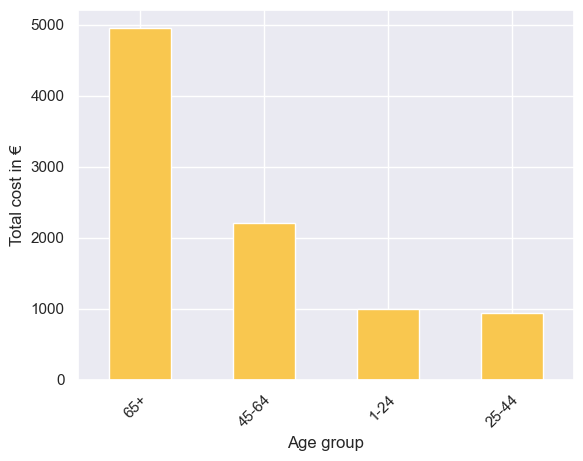

In [125]:
age_group = TZA.groupby(['age_group'])['total_cost_Euro'].median()
age_group = age_group.sort_values(ascending=False)
ax = age_group.plot.bar(x='age_group', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Age group')
plt.ylabel('Total cost in €');

The older the tourist, the more they spend on their holidays. (Hypothesis confirmed.)

Now I check the travel_with feature accordlingly.

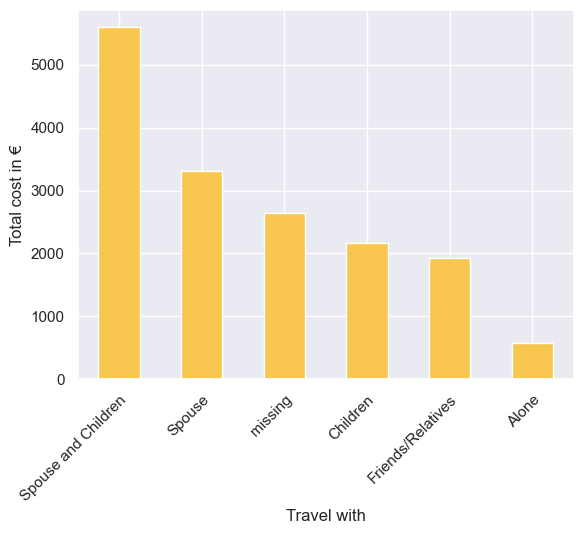

In [126]:
travel_with = TZA.groupby(['travel_with'])['total_cost_Euro'].median()
travel_with = travel_with.sort_values(ascending=False)
ax = travel_with.plot.bar(x='travel_with', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Travel with')
plt.ylabel('Total cost in €');

While the group size didn't have a great effect, we can see here a correlation: Tourists who travel with their entire family spend significantly more than others, while alone travellers spend least. (This partially confirms one of my hypotheses.)

Now let's the the impact of the travel purpose.

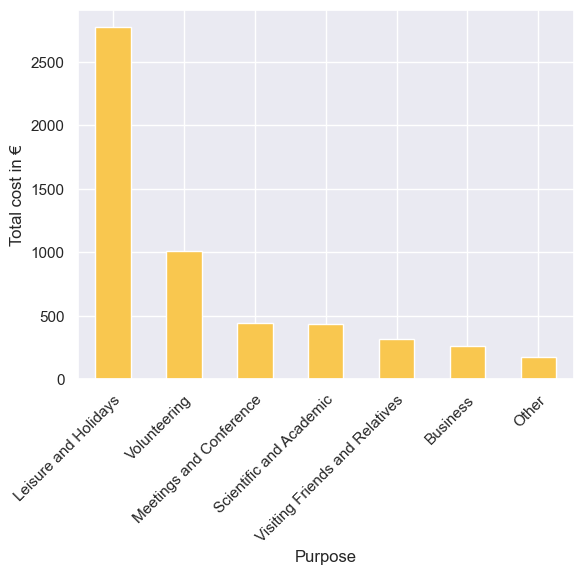

In [127]:
purpose = TZA.groupby(['purpose'])['total_cost_Euro'].median()
purpose = purpose.sort_values(ascending=False)
ax = purpose.plot.bar(x='purpose', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Purpose')
plt.ylabel('Total cost in €');

Those who visit Tanzania for Leisure and Holidays spend by far the most.

And now we check the main activities accordingly.

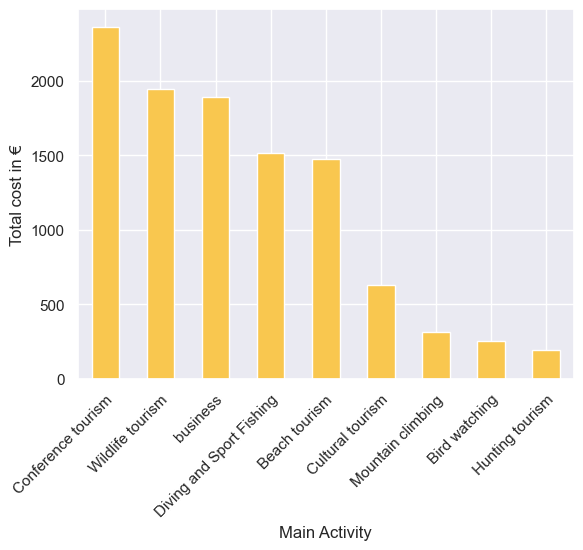

In [130]:
activity = TZA.groupby(['main_activity'])['total_cost_Euro'].median()
activity = activity.sort_values(ascending=False)
ax = activity.plot.bar(x='main_activity', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Main Activity')
plt.ylabel('Total cost in €');

I'm not surprised that mountain climbers and bird watchers don't spend that much while I had a totally different picture of (big game) hunters in my head... We see that the main activity has an impact on the total cost. Conference tourists spend most.

I wonder if the source of information has an impact on the cost?

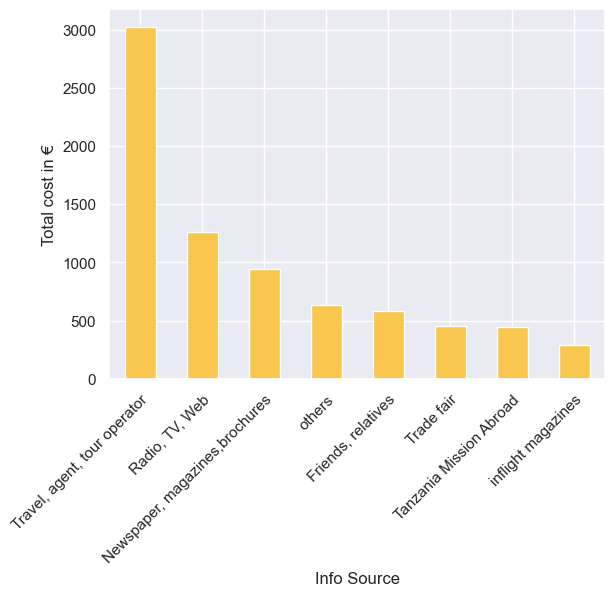

In [133]:
info_source = TZA.groupby(['info_source'])['total_cost_Euro'].median()
info_source = info_source.sort_values(ascending=False)
ax = info_source.plot.bar(x='info_source', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Info Source')
plt.ylabel('Total cost in €');

Those who make use of an agency or tour operator spend by far most. I assume that people who use these services are a bit more affluent anyway.

Now let's check whether the hypothesis that travellers with arranged tours spend more than independend travellers is confirmed.

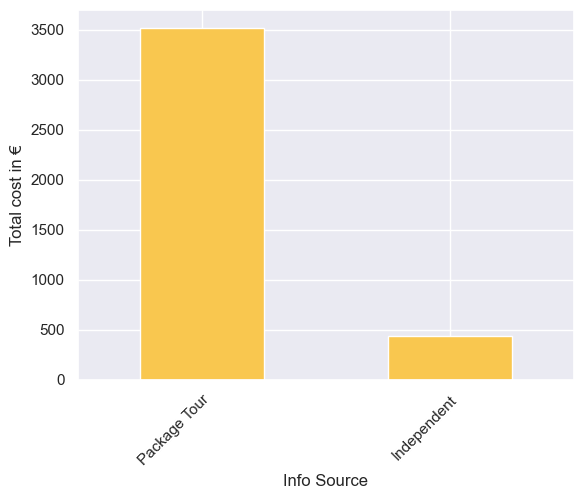

In [135]:
tour_arrangement = TZA.groupby(['tour_arrangement'])['total_cost_Euro'].median()
tour_arrangement = tour_arrangement.sort_values(ascending=False)
ax = tour_arrangement.plot.bar(x='tour_arrangement', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Info Source')
plt.ylabel('Total cost in €');

Definitely!

Now I'll create some plots which show in how far the total costs are affected by the services which are included. However, not only those travelers who indicated that they had used an arrangement are included here, but also independent travelers.

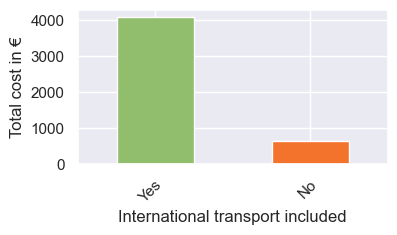

In [139]:
package_transport_int = TZA.groupby(['package_transport_int'])['total_cost_Euro'].median()
package_transport_int = package_transport_int.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_transport_int.plot.bar(x='package_transport_int', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('International transport included')
plt.ylabel('Total cost in €');

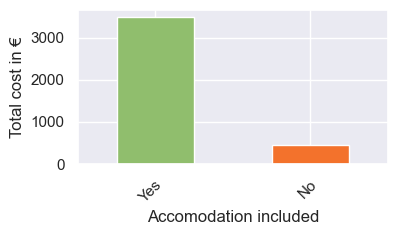

In [141]:
package_accomodation = TZA.groupby(['package_accomodation'])['total_cost_Euro'].median()
package_accomodation = package_accomodation.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_accomodation.plot.bar(x='package_accomodation', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Accomodation included')
plt.ylabel('Total cost in €');

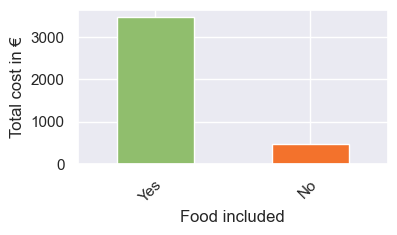

In [142]:
package_food = TZA.groupby(['package_food'])['total_cost_Euro'].median()
package_food = package_food.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_food.plot.bar(x='package_food', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Food included')
plt.ylabel('Total cost in €');

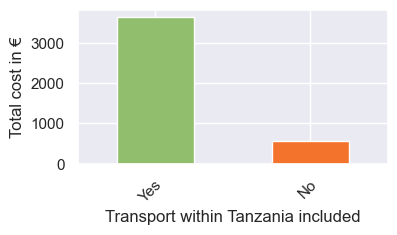

In [143]:
package_transport_tz = TZA.groupby(['package_transport_tz'])['total_cost_Euro'].median()
package_transport_tz = package_transport_tz.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_transport_tz.plot.bar(x='package_transport_tz', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Transport within Tanzania included')
plt.ylabel('Total cost in €');

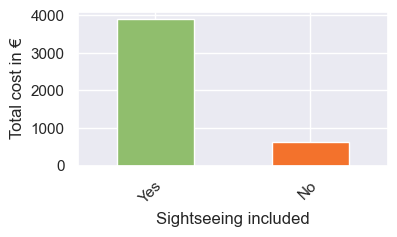

In [144]:
package_sightseeing = TZA.groupby(['package_sightseeing'])['total_cost_Euro'].median()
package_sightseeing = package_sightseeing.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_sightseeing.plot.bar(x='package_sightseeing', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Sightseeing included')
plt.ylabel('Total cost in €');

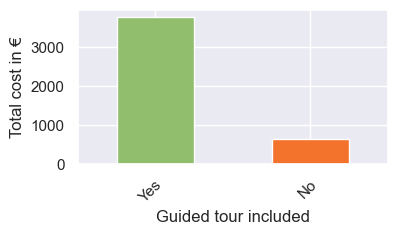

In [145]:
package_guided_tour = TZA.groupby(['package_guided_tour'])['total_cost_Euro'].median()
package_guided_tour = package_guided_tour.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_guided_tour.plot.bar(x='package_guided_tour', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Guided tour included')
plt.ylabel('Total cost in €');

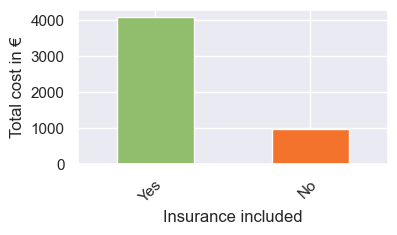

In [146]:
package_insurance = TZA.groupby(['package_insurance'])['total_cost_Euro'].median()
package_insurance = package_insurance.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_insurance.plot.bar(x='package_insurance', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Insurance included')
plt.ylabel('Total cost in €');

We see that having booked these services impacts the costs. This is not surprising. (If we wanted to examine more closely only those travelers with tour arrangements, we could do the previous plots again with just those travelers. I don't do that now, though, and I'll let the model judge the exact impact of each service later.)

I'm curious if the payment method impacts the total costs.

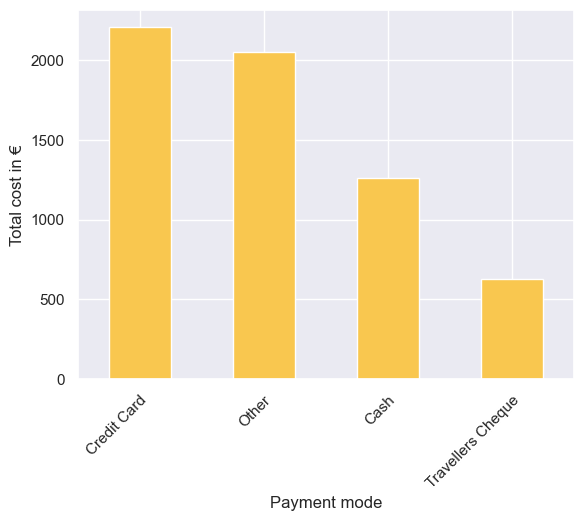

In [150]:
payment_mode = TZA.groupby(['payment_mode'])['total_cost_Euro'].median()
payment_mode = payment_mode.sort_values(ascending=False)
ax = payment_mode.plot.bar(x='payment_mode', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Payment mode')
plt.ylabel('Total cost in €');

As we can see, credit card users spend most, followed by 'other' (whatever this is...), travellers cheque users spend least.
Now let's see whether first time visitors spend more or less than repeat vistors.

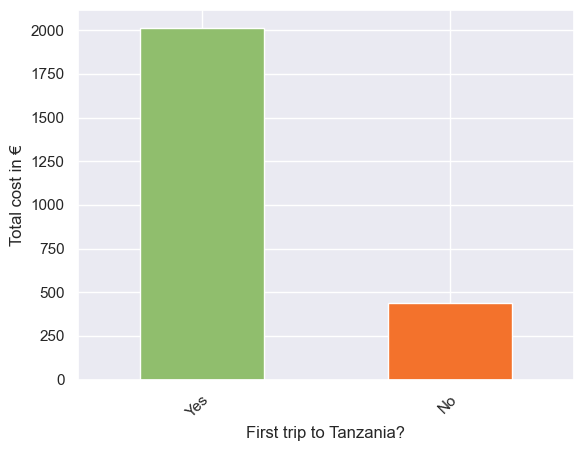

In [155]:
first_trip_tz = TZA.groupby(['first_trip_tz'])['total_cost_Euro'].median()
first_trip_tz = first_trip_tz.sort_values(ascending=False)
ax = first_trip_tz.plot.bar(x='first_trip_tz', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('First trip to Tanzania?')
plt.ylabel('Total cost in €');

They do!

I wonder if what tourists find most impressive has an impact on the overall cost?

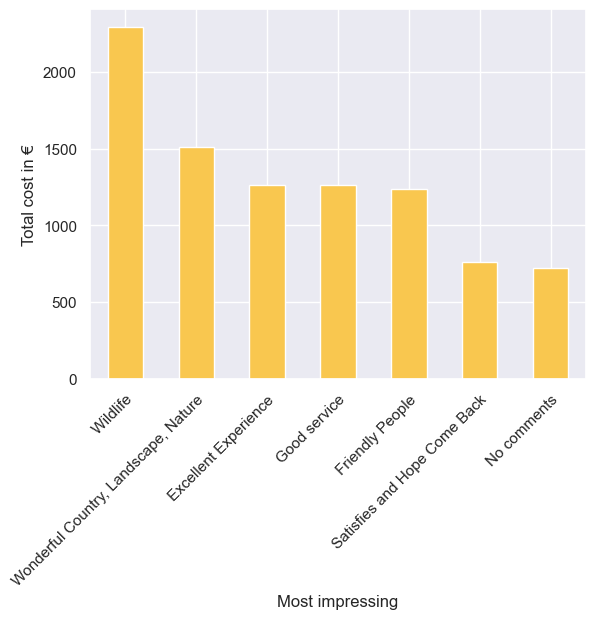

In [154]:
most_impressing = TZA.groupby(['most_impressing'])['total_cost_Euro'].median()
most_impressing = most_impressing.sort_values(ascending=False)
ax = most_impressing.plot.bar(x='most_impressing', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Most impressing')
plt.ylabel('Total cost in €');

Not too much. We already know that wildlife tourists are relatively generous. I would imagine that this feature won't play a big role for the model.

The tourists of which sub region of origin probably spend the most?

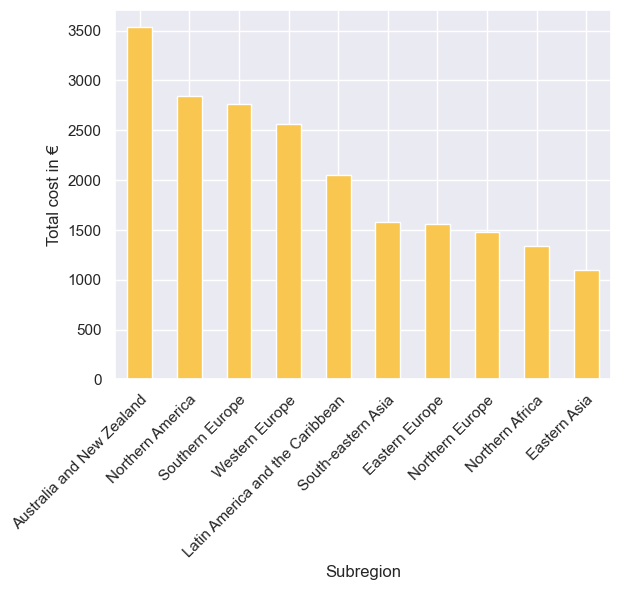

In [158]:
sub_region = TZA.groupby(['sub_region'])['total_cost_Euro'].median()
sub_region = sub_region.sort_values(ascending=False).head(10)
ax = sub_region.plot.bar(x='sub_region', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Subregion')
plt.ylabel('Total cost in €');

Those from Australia and New Zealand. Tourists from East Asia spend the least.

Now let's check whether the duration of the stay impacts the total cost.

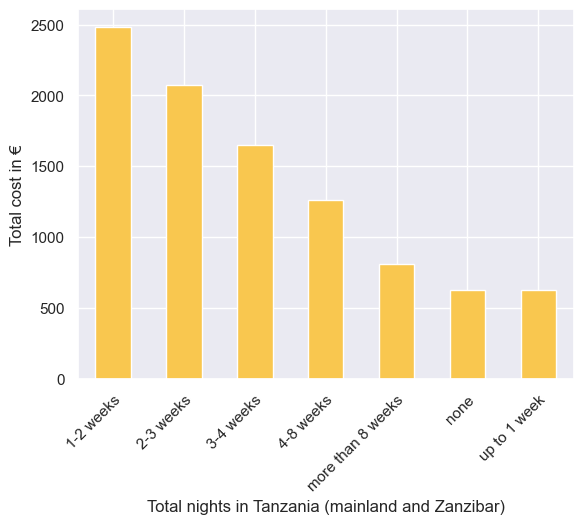

In [162]:
total_nights_binned = TZA.groupby(['total_nights_binned'])['total_cost_Euro'].median()
total_nights_binned = total_nights_binned.sort_values(ascending=False)
ax = total_nights_binned.plot.bar(x='total_nights_binned', y='total_cost_Euro', rot=0, color='#f9c74f')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Total nights in Tanzania (mainland and Zanzibar)')
plt.ylabel('Total cost in €');

In [79]:
TZA.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost', 'group_size', 'sub_region', 'total_nights',
       'nights_mainland_binned', 'nights_zanzibar_binned',
       'total_nights_binned', 'total_cost_Euro'],
      dtype='object')